<a href="https://colab.research.google.com/github/jaeyoonjeong9024/8-weeks/blob/main/SE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# Google Colab 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# 필요 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Conv1D, MaxPooling1D, concatenate,
    GlobalAveragePooling1D, Reshape, multiply # 💡 SE에 필요
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [14]:
# (원본) 파일 로드
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# (원본) 파일 그룹 로드
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    loaded = np.dstack(loaded)
    return loaded

# (원본) 데이터셋 그룹 로드 (train 또는 test)
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # 9개 파일명 생성 (acc 3+3, gyro 3)
    filenames = list()
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # 로드
    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

# (원본) 전체 데이터셋 로드
def load_dataset(prefix=''):
    base_path = prefix + '/content/drive/MyDrive/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/'
    trainX, trainy = load_dataset_group('train', base_path)
    testX, testy = load_dataset_group('test', base_path)
    # 레이블 0-5로 조정 및 원-핫 인코딩
    trainy = trainy - 1
    testy = testy - 1
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print("trainX shape:", trainX.shape, " testX shape:", testX.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [15]:
# 데이터 로드
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

# 학습/검증 데이터 분할
X_train, X_val, y_train_one_hot, y_val_one_hot = train_test_split(
    trainX, trainy_one_hot, test_size=0.2, random_state=100
)

# 모델 파라미터 설정
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = y_train_one_hot.shape[1]

/tmp/ipython-input-4245881589.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-4245881589.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-4245881589.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-4245881589.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


trainX shape: (7352, 128, 9)  testX shape: (2947, 128, 9)


/tmp/ipython-input-4245881589.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


In [16]:
def se_block(input_tensor, reduction_ratio=16):
    channels = input_tensor.shape[-1]
    # Squeeze
    squeeze = GlobalAveragePooling1D()(input_tensor)
    # Excitation
    excitation = Dense(channels // reduction_ratio, activation='relu')(squeeze)
    excitation = Dense(channels, activation='sigmoid')(excitation)
    # Rescale
    scale = Reshape((1, channels))(excitation)
    return multiply([input_tensor, scale])

In [17]:
## Level_1
inputs1_1= Input(shape=(n_timesteps,n_features))
conv1_1 = Conv1D(filters=128, kernel_size=3, activation='relu')(inputs1_1)
inputs1_2= Input(shape=(n_timesteps,n_features))
conv1_2 = Conv1D(filters=128, kernel_size=5, activation='relu')(inputs1_2)
inputs1_3= Input(shape=(n_timesteps,n_features))
conv1_3 = Conv1D(filters=128, kernel_size=7, activation='relu')(inputs1_3)
inputs1_4= Input(shape=(n_timesteps,n_features))
conv1_4 = Conv1D(filters=128, kernel_size=9, activation='relu')(inputs1_4)
# merge1
merged_1 = concatenate([conv1_1,conv1_2,conv1_3,conv1_4],axis=1)
se_1 = se_block(merged_1) # 💡 (추가)
pool_1 = MaxPooling1D(pool_size=5)(se_1) # 💡 (수정) 입력을 se_1으로

## Level_2
conv2_1 = Conv1D(filters=64, kernel_size=3, activation='relu')(pool_1)
conv2_2 = Conv1D(filters=64, kernel_size=5, activation='relu')(pool_1)
conv2_3 = Conv1D(filters=64, kernel_size=7, activation='relu')(pool_1)
conv2_4 = Conv1D(filters=64, kernel_size=9, activation='relu')(pool_1)
# merge2
merged_2 = concatenate([conv2_1,conv2_2,conv2_3,conv2_4],axis=1)
se_2 = se_block(merged_2) # 💡 (추가)
pool_2 = MaxPooling1D(pool_size=5)(se_2) # 💡 (수정) 입력을 se_2로

## Level_3
conv3_1 = Conv1D(filters=32, kernel_size=3, activation='relu')(pool_2)
conv3_2 = Conv1D(filters=32, kernel_size=5, activation='relu')(pool_2)
conv3_3 = Conv1D(filters=32, kernel_size=7, activation='relu')(pool_2)
conv3_4 = Conv1D(filters=32, kernel_size=9, activation='relu')(pool_2)
# merge
merged_3 = concatenate([conv3_1,conv3_2,conv3_3,conv3_4],axis=1)
se_3 = se_block(merged_3) # 💡 (추가)
pool_3 = MaxPooling1D(pool_size=5)(se_3) # 💡 (수정) 입력을 se_3으로

## (원본과 동일)
flat_cnn=Flatten()(pool_3)
dense = Dense(512, activation='relu')(flat_cnn)
outputs = Dense(n_outputs, activation='softmax')(dense)

## (원본과 동일) 4-입력 구조
se_model = Model([inputs1_1, inputs1_2, inputs1_3,inputs1_4], outputs)

In [18]:
se_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
se_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_24 (Conv1D)  │ (None, 126, 128)  │      3,584 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_25 (Conv1D)  │ (None, 124, 128)  │      5,888 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_26 (Conv1D)  │ (None, 122, 128)  │      8,192 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_27 (Conv1D)  │ (None, 120, 128)  │     10,496 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 492, 128)  │          0 │ conv1d_24[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_25[0][0],  │
│                     │                   │            │ conv1d_26[0][0],  │
│                     │                   │            │ conv1d_27[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ concatenate_3[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8)         │      1,032 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │      1,152 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 128)    │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 492, 128)  │          0 │ concatenate_3[0]… │
│                     │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 98, 128)   │          0 │ multiply[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 96, 64)    │     24,640 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 94, 64)    │     41,024 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_30 (Conv1D)  │ (None, 92, 64)    │     57,408 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 90, 64)    │     73,792 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 372, 64)   │          0 │ conv1d_28[0][0],

 Total params: 1,181,940 (4.51 MB)

 Trainable params: 1,181,940 (4.51 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
print("SE-CNN (4-Input) 모델 학습 시작...")

model_history = se_model.fit(
    x=[X_train, X_train, X_train, X_train], # 💡 (원본 방식 유지)
    y=y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_data=([X_val, X_val, X_val, X_val], y_val_one_hot)
)

print("학습 완료.")

SE-CNN (4-Input) 모델 학습 시작...
Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 60s 292ms/step - accuracy: 0.6950 - loss: 0.7127 - val_accuracy: 0.9273 - val_loss: 0.1553
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 84s 306ms/step - accuracy: 0.9496 - loss: 0.1284 - val_accuracy: 0.9517 - val_loss: 0.1144
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 40s 216ms/step - accuracy: 0.9522 - loss: 0.1097 - val_accuracy: 0.9538 - val_loss: 0.1080
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 45s 237ms/step - accuracy: 0.9602 - loss: 0.0968 - val_accuracy: 0.9409 - val_loss: 0.1388
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 42s 228ms/step - accuracy: 0.9487 - loss: 0.1313 - val_accuracy: 0.9551 - val_loss: 0.1122
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 81s 222ms/step - accuracy: 0.9566 - loss: 0.1005 - val_accuracy: 0.9354 - val_loss: 0.1342
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 40s 220ms/step - accuracy: 0.9535 - loss: 0.1024 - val_accuracy: 0.9545 - val_loss: 0.0997
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 38s 209ms/step

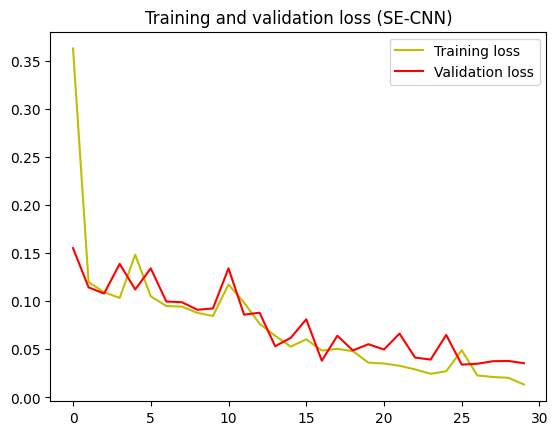

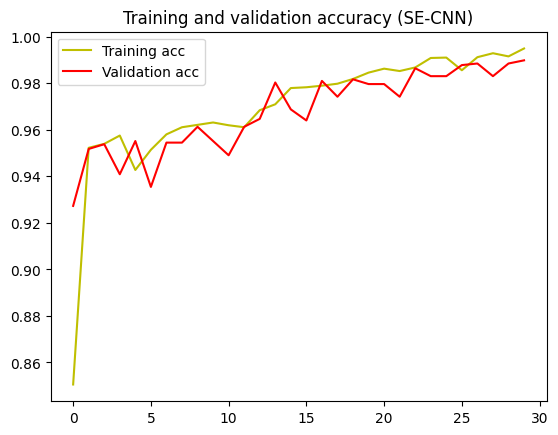

In [20]:
# 손실(Loss) 그래프
plt.plot(model_history.history['loss'], 'y', label='Training loss')
plt.plot(model_history.history['val_loss'], 'r', label='Validation loss')
plt.title('Training and validation loss (SE-CNN)')
plt.legend()
plt.show()

# 정확도(Accuracy) 그래프
plt.plot(model_history.history['accuracy'], 'y', label='Training acc')
plt.plot(model_history.history['val_accuracy'], 'r', label='Validation acc')
plt.title('Training and validation accuracy (SE-CNN)')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step
--- Confusion Matrix ---
[[467  23   5   0   1   0]
 [ 11 454   6   0   0   0]
 [  0   0 420   0   0   0]
 [  0   3   0 382 100   6]
 [  0   2   0  11 519   0]
 [  0   0   0   0   0 537]]

--- Accuracy Score ---
0.9429928741092637

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       496
           1       0.94      0.96      0.95       471
           2       0.97      1.00      0.99       420
           3       0.97      0.78      0.86       491
           4       0.84      0.98      0.90       532
           5       0.99      1.00      0.99       537

    accuracy                           0.94      2947
   macro avg       0.95      0.94      0.94      2947
weighted avg       0.95      0.94      0.94      2947



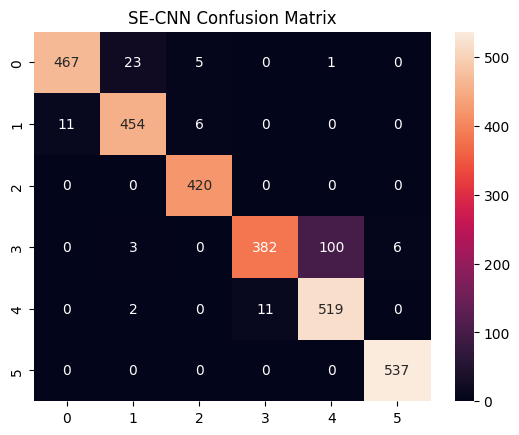

In [21]:
# 예측
pred_se = se_model.predict([testX, testX, testX, testX]) # 💡 (원본 방식 유지)
pred_classes = np.argmax(pred_se, axis=-1)

# 평가
cm = confusion_matrix(testy, pred_classes)
print("--- Confusion Matrix ---")
print(cm)
print("\n--- Accuracy Score ---")
print(accuracy_score(testy, pred_classes))
print("\n--- Classification Report ---")
print(classification_report(testy, pred_classes))

# Heatmap
sns.heatmap(cm, annot=True, fmt='d')
plt.title('SE-CNN Confusion Matrix')
plt.show()